In [11]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

there will be two "main files". one jupyter notebook for development and another python file containing the same code, so that it can be imported into the unit testing and continuous integration.

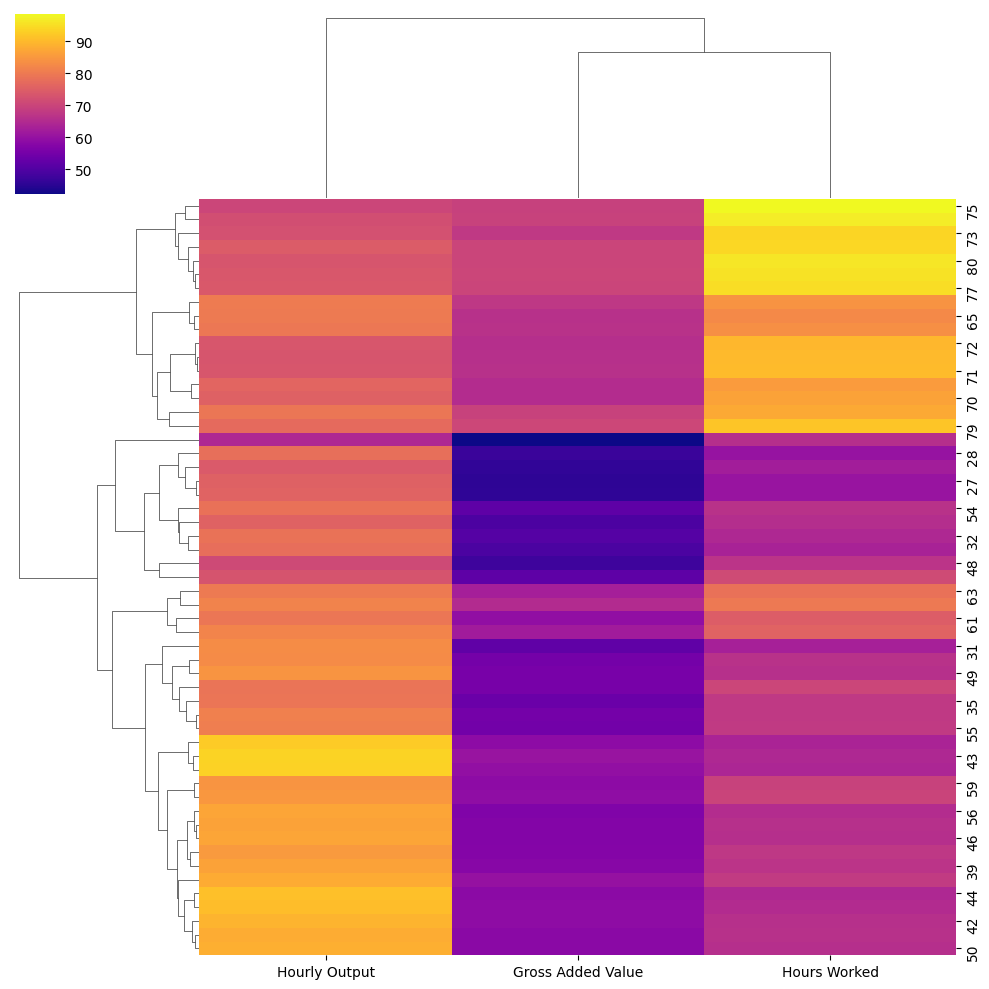

In [ ]:

"""
cluster of all values, seeing at a glance which is the strongest
zooming in by doing a correlation matrix
see what variables have the highest AND LOWEST correlation 
its likely to be the variables we looked at before
take them at a larger scale and correlate the two variables
then you have to question - correlation or causation???
"""

mc_final = pd.read_csv('../datasets/management_consulting_final.csv')

cols = ['Gross Added Value', 'Hours Worked', 'Hourly Output']
mc_subset = mc_final[cols]
sns.clustermap(mc_subset.T, cmap='plasma')

In [27]:
matrix = np.corrcoef(mc_final['Hours Worked'], mc_final['Gross Added Value'])
print(matrix)

[[1.        0.9380608]
 [0.9380608 1.       ]]
